# Import Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from transformers import pipeline
from wordcloud import WordCloud
import string
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
pd.set_option('display.max_colwidth', 1)
# ignore warning
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

# Pelabelan Data


## Lexicon Based

Karena data review yang kita miliki masih belum memiliki label yang dimana label tersebut akan digunakan dalam modeling menggunakan algoritma klasifikasi. Untuk itu kita akan menambahkan label kedataset kita dengan cara menghitung score dari setiap kata untuk setiap observasi dan jika hasilnya <0 maka labelnya adalah `negative` dan jika >0 maka labelnya adalah `positive` dan jika score dalam 1 kalimat tersebut = 0 maka labelnya adalah `neutral`.

In [2]:
# memuat dan menampilkan 5 data pertama
df = pd.read_csv('dataset/cleaned_data.csv')
df.head()

,review,years,month
0,kemas beda salah dalam beda kirim cepat pakai sicepat terimakasih msglow,2021,11
1,alhamdulillah banget barang dalem aman cacat sesuai alhamdulillah packing oke kirim oke moga cocok,2022,5
2,kualitas produk harga produk cepat kirim cepat kirim respon jual jahat asli lingkung kondisi rubah,2023,7
3,produk packing rapih kirim cepat emas cepat terimakasih msglow,2021,10
4,emas cepat packing aman produk expired tekstur kental aplikasi wajah cepat resap coba moga cocok pakai,2021,4


In [3]:
df.shape

(2281, 3)

In [4]:
# membaca file lexicon positive dan negative untuk pelabelan
lexicon_positive = dict()
with open('dataset/text-library/lexicon_positive_ver1.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])

lexicon_negative = dict()
with open('dataset/text-library/lexicon_negative_ver1.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])

def sentiment_analysis_lexicon_indonesia(text):
  score = 0
  for word_pos in text:
    if (word_pos in lexicon_positive):
      score = score + lexicon_positive[word_pos]
  for word_neg in text:
    if (word_neg in lexicon_negative):
      score = score + lexicon_negative[word_neg]
  Sentimen=''
  if (score > 0):
    Sentimen = 'Positive'
  elif (score < 0):
    Sentimen = 'Negative'
  else:
    Sentimen = 'Neutral'
  
  return score, Sentimen

In [5]:
# menerapkan fungsi kesetiap observasi data
df.review= df.review.str.split()
results = df['review'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df['score'] = results[0]
df['sentimen'] = results[1]
df.review = df.review.str.join(' ')

In [6]:
# memeriksa hasil akhir
df.head()

,review,years,month,score,sentimen
0,kemas beda salah dalam beda kirim cepat pakai sicepat terimakasih msglow,2021,11,3,Positive
1,alhamdulillah banget barang dalem aman cacat sesuai alhamdulillah packing oke kirim oke moga cocok,2022,5,15,Positive
2,kualitas produk harga produk cepat kirim cepat kirim respon jual jahat asli lingkung kondisi rubah,2023,7,18,Positive
3,produk packing rapih kirim cepat emas cepat terimakasih msglow,2021,10,10,Positive
4,emas cepat packing aman produk expired tekstur kental aplikasi wajah cepat resap coba moga cocok pakai,2021,4,2,Positive


In [7]:
# memeriksa nilai pada kolom sentimen
df.sentimen.value_counts()

sentimen
Positive    1842
Negative    339 
Neutral     100 
Name: count, dtype: int64

# Exploratory Data Analysis (EDA)

## Distribusi Data Sentimen Terhadap Produk

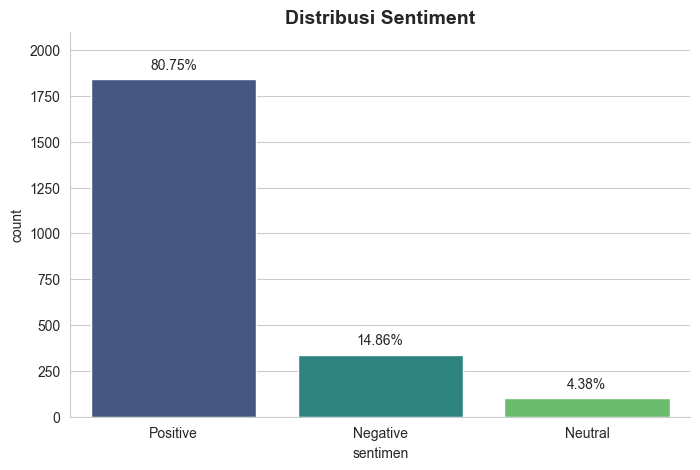

In [8]:
# visualisasi distribusi jumlah sentimen terhadap produk skincare
plt.figure(figsize=(8,5))

sns.set_style('whitegrid')
ax = sns.countplot(data=df, x='sentimen', palette='viridis')
sns.despine(ax=ax, top=True, right=True)

for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(f'{height / float(len(df)) * 100:.2f}%',
                (bar.get_x() + bar.get_width() / 2, height),
                ha='center', va='center',
                size=10,
                xytext=(0, 10),
                textcoords='offset points',)

plt.title('Distribusi Sentiment', size=14, fontweight='bold')
plt.ylim(0, 2100)  
plt.show()

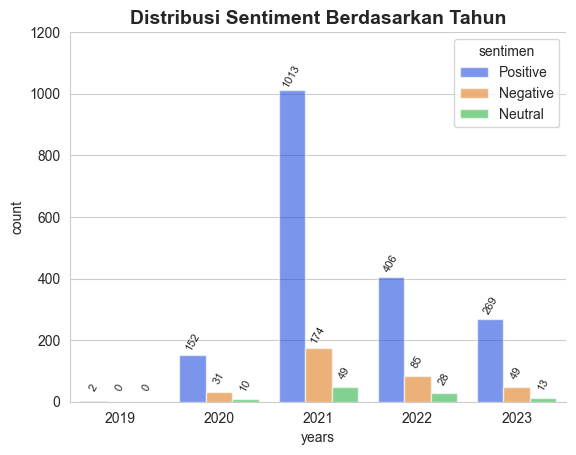

In [9]:
sentimen_by_years = df.pivot_table(index=['years','sentimen'], values='review', aggfunc='count').reset_index()
#
sns.set_style('whitegrid')
ax = sns.countplot(data=df, x='years', hue='sentimen', palette='bright', alpha=0.6)
sns.despine(ax=ax, top=True, right=True)

for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(format(bar.get_height().astype('int')),
                (bar.get_x() + bar.get_width() / 2, height),
                ha='center', va='center',
                size=8,
                xytext=(0, 10),
                textcoords='offset points', rotation=60)

plt.title('Distribusi Sentiment Berdasarkan Tahun', size=14, fontweight='bold')
plt.ylim(0, 1200)  # Mengganti label sumbu Y menjadi 'Persentase'
plt.show()

**Kesimpulan**

Secara umum produk skincare MsGlow mendapat penilaian yang positive dari masyarakat setiap tahunnya dimana angka persentase untuk sentiment positive keseluruhan yaitu sebanyak `80.75%`. Akan tetapi, produk ini terjadi penurunan popularitasnya setelah tahun 2021 dimana kita bisa melihat bahwa untuk pengguna memberikan responden yang lebih sedikit. 

## WordCloud

Selanjutnya kita akan mencoba menampilkan wordcloud dari data kita, tujuannya adalah kata apa sih yang sering dilontarkan para pengguna untuk produk skincare ini. 

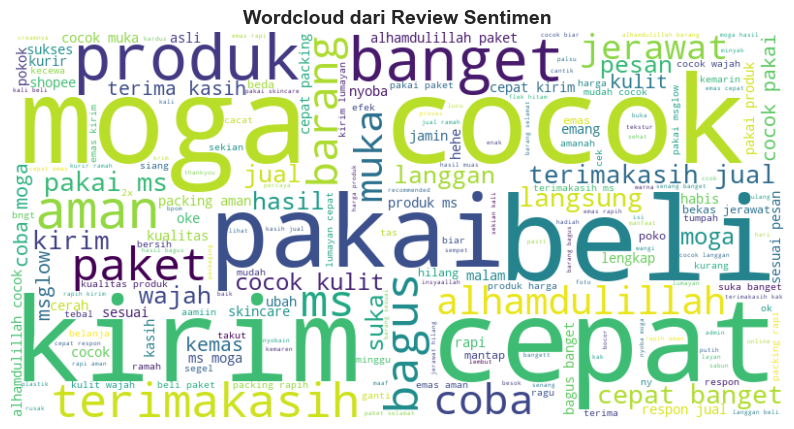

In [10]:
# menghapus karakter khusus dan angka
df['review_clean'] = df['review'].str.replace('[{}]'.format(string.punctuation), '')
df['review_clean'] = df['review_clean'].str.replace('\d+', '')

# tokenisasi kata-kata
words = ' '.join(df['review_clean']).lower()
tokens = word_tokenize(words)

text = ' '.join(tokens)

# membuat Wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plotting Wordcloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud dari Review Sentimen', size=14, fontweight='bold')
plt.show()

# Modeling

Kita sebelumnya sudah mengetahui bahwa label target memiliki komposisi tidak seimbang, dimana kelas positif lebih banyak dari pada kelas negatif dan neutral. Untuk itu kita akan membuat perbandingan model antara *imbalance class* dan *balanced class*. Dan satu hal yang perlu diingat bahwa untuk menilai model dengan class imbalance adalah metriks f1-score. 


## Membagi Features dan Target

In [11]:
# data features
features = df.review
# data target
target = df.sentimen

## Standarisasi atau Normalisasi Data

In [12]:
# inisialisasi
tf_idf = TfidfVectorizer()
# normalisasi feature
x_tf_idf = tf_idf.fit_transform(features).toarray()
# menampilkan ukuran dari feature yang telah dinormalisasi dengan tf-idf vectorize
x_tf_idf.shape

(2281, 4236)

## Training dengan Imbalance Class

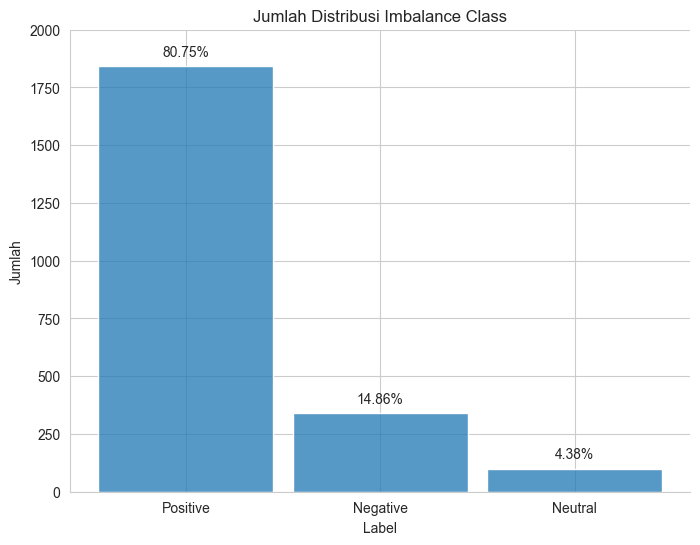

In [13]:
# menampilkan distribusi setelah di resampling
sns.set_style(style='whitegrid')
plt.figure(figsize=(8, 6))

# visualisasi untuk kelas target
ax = sns.histplot(target, shrink=0.9)
sns.despine(ax=ax, top=True, right=True)

for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(f'{height / float(len(target)) * 100:.2f}%',
                (bar.get_x() + bar.get_width() / 2, height),
                ha='center', va='center',
                size=10,
                xytext=(0, 10),
                textcoords='offset points',)

# pengaturan plot
plt.title('Jumlah Distribusi Imbalance Class')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.ylim(0, 2000)
plt.show()

In [14]:
# inisialisasi train_size
train_sizes = np.arange(0.5, 0.91, 0.1)

# list untuk menyimpan performa model
train_acc = []
test_acc = []
model_name = []
trains_size = []
train_f1scores = []
test_f1scores = []

for size in train_sizes:
    # splitting data
    features_train, features_test, target_train, target_test = train_test_split(x_tf_idf, target, stratify=target, train_size=size, random_state=12345)

    # Inisialisasi model SVM
    model = SVC(kernel='linear', random_state=12345)
    name = model.__class__.__name__
    # 
    model.fit(features_train, target_train)
    #
    target_pred_train = model.predict(features_train)
    target_pred_test = model.predict(features_test)
    # f1_score
    f1scores_test = f1_score(target_test, target_pred_test, average='macro')
    f1scores_train = f1_score(target_train, target_pred_train, average='macro')
    # accuracy
    accuracy_train = accuracy_score(target_train, target_pred_train)
    accuracy_test = accuracy_score(target_test, target_pred_test)
    # menghitung rata-rata akurasi dari cross-validation
    train_acc.append(accuracy_train)
    test_acc.append(accuracy_test)
    model_name.append(name)
    trains_size.append(f'{size:.0%}')
    train_f1scores.append(f1scores_train)
    test_f1scores.append(f1scores_test)



In [15]:
# performa model dalam bentuk dataframe
result_svm_imbalance = pd.DataFrame({
    'model_name' : model_name,
    'train_size' : trains_size,
    'train_accuracy' : train_acc,
    'train_f1-score': train_f1scores,
    'test_accuracy' : test_acc,
    'test_f1-score' : test_f1scores

})
result_svm_imbalance

,model_name,train_size,train_accuracy,train_f1-score,test_accuracy,test_f1-score
0,SVC,50%,0.950877,0.753377,0.838738,0.438452
1,SVC,60%,0.954678,0.763664,0.837897,0.435400
2,SVC,70%,0.954887,0.763078,0.855474,0.476391
3,SVC,80%,0.958882,0.791518,0.859956,0.487305
4,SVC,90%,0.957602,0.780969,0.886463,0.542432


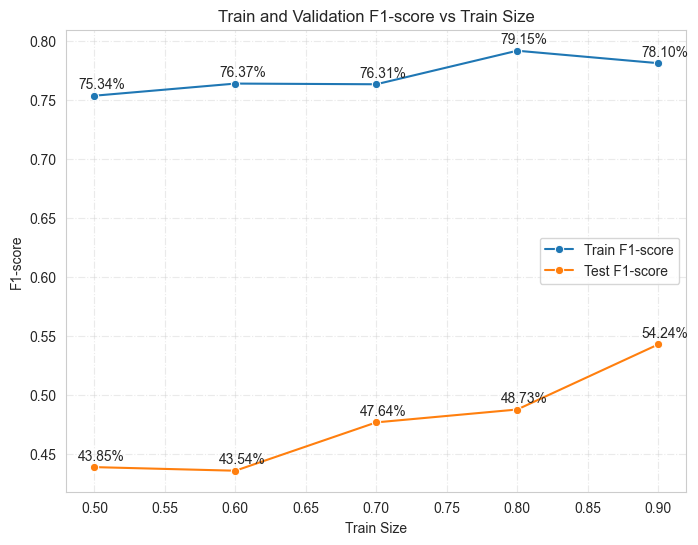

In [16]:
plt.figure(figsize=(8, 6))

# Memplot grafik F1-score untuk data latih (Train F1-score) dan data validasi (Test F1-score)
sns.lineplot(x=train_sizes, y=train_f1scores, label='Train F1-score', marker='o')
sns.lineplot(x=train_sizes, y=test_f1scores, label='Test F1-score', marker='o')

# Pengaturan plot
plt.title('Train and Validation F1-score vs Train Size')
plt.xlabel('Train Size')
plt.ylabel('F1-score')
plt.legend(loc='center right')
plt.grid(True, linestyle='-.', alpha=0.4)
# Anotasi untuk setiap titik data
for i, txt in enumerate(test_f1scores):
    plt.annotate(f'{txt:.2%}', (train_sizes[i], test_f1scores[i]), textcoords="offset points", xytext=(5,5), ha='center')
for i, txt in enumerate(train_f1scores):
    plt.annotate(f'{txt:.2%}', (train_sizes[i], train_f1scores[i]), textcoords="offset points", xytext=(5,5), ha='center')

plt.show()


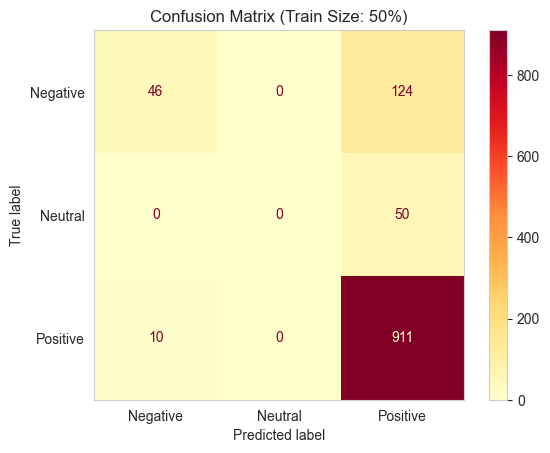

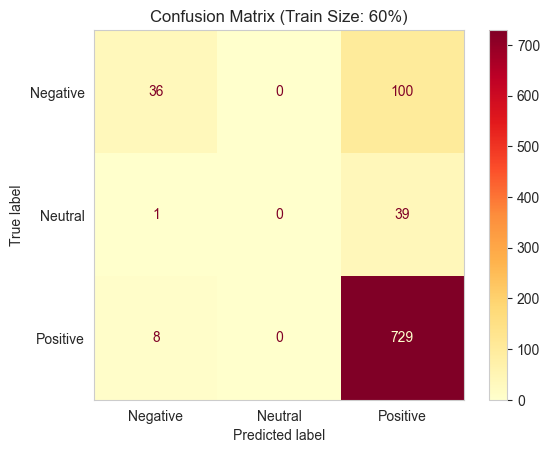

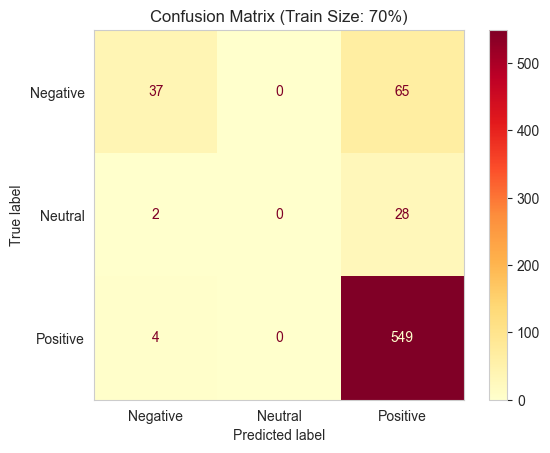

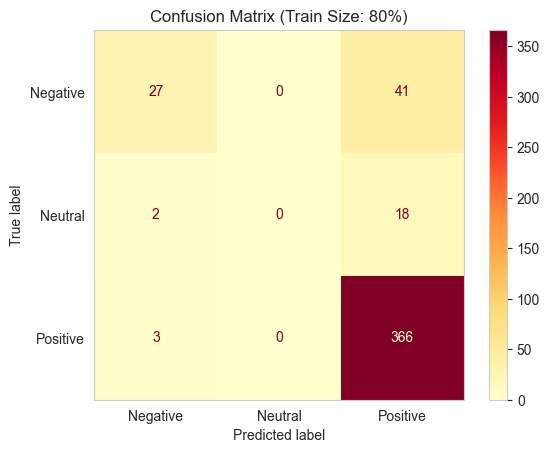

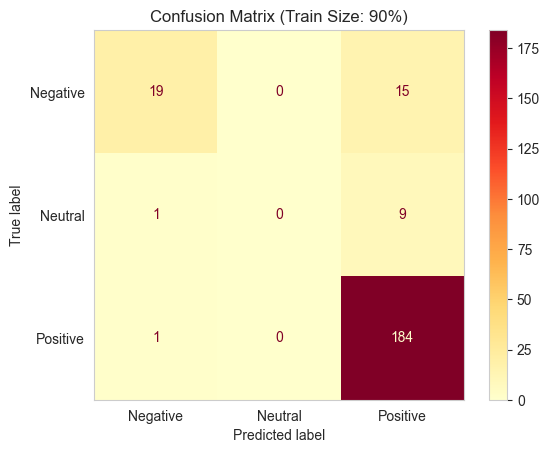

In [17]:
# confusion metriks untuk model dengan imbalance class
for size in train_sizes:
        # splitting data
        features_train, features_test, target_train, target_test = train_test_split(x_tf_idf, target, stratify=target, train_size=size, random_state=12345)

        # Inisialisasi model SVM
        model = SVC(kernel='linear', random_state=12345)
        name = model.__class__.__name__
        # 
        model.fit(features_train, target_train)
        #
        target_pred_test = model.predict(features_test)
        #
        cm = confusion_matrix(target_test, target_pred_test)
        # plot confusion matrix
        cm = confusion_matrix(target_test, target_pred_test, labels=np.unique(target))

        # Menampilkan confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(target))
        disp.plot(cmap=plt.cm.YlOrRd)
        plt.title(f'Confusion Matrix (Train Size: {size:.0%})')
        plt.grid(False)
        plt.show()

In [18]:
# cclassification report untuk balanced class dengan smote
for size in train_sizes:
        # splitting data
        features_train, features_test, target_train, target_test = train_test_split(x_tf_idf, target, stratify=target, train_size=size, random_state=12345)

        # Inisialisasi model SVM
        model = SVC(kernel='linear', random_state=12345)
        name = model.__class__.__name__
        # 
        model.fit(features_train, target_train)
        #
        target_pred_test = model.predict(features_test)

        print(f'Data Training {size:.0%}'.center(55, '-'))
        print(classification_report(target_test, target_pred_test, zero_division=0))
        print(55*'=')


-------------------Data Training 50%-------------------
              precision    recall  f1-score   support

    Negative       0.82      0.27      0.41       170
     Neutral       0.00      0.00      0.00        50
    Positive       0.84      0.99      0.91       921

    accuracy                           0.84      1141
   macro avg       0.55      0.42      0.44      1141
weighted avg       0.80      0.84      0.79      1141

-------------------Data Training 60%-------------------
              precision    recall  f1-score   support

    Negative       0.80      0.26      0.40       136
     Neutral       0.00      0.00      0.00        40
    Positive       0.84      0.99      0.91       737

    accuracy                           0.84       913
   macro avg       0.55      0.42      0.44       913
weighted avg       0.80      0.84      0.79       913

-------------------Data Training 70%-------------------
              precision    recall  f1-score   support

    Negative   

Sepertinya dataset kita mengalami over fitting dimana arti over fitting adalah performa model untuk data training lebih tinggi dari pada untuk data testing karena model tidak cukup baik dalam memprediksi data baru, kemudian untuk metriks f1-score juga tidak cukup baik akan tetapi model kita memiliki performa yang semakin meningkat jika data training yang semakin banyak. 

Satu hal yang perlu diingat adalah ketika memiliki data dengan *imbalance class* kinerja metrik f1-score menjadi penting untuk memberikan gambaran yang lebih baik tentang seberapa baik model  bekerja dalam situasi dimana kelas-kelas memiliki distribusi yang tidak merata.
Dalam situasi di mana kelas-kelas memiliki jumlah sampel yang sangat tidak seimbang (misalnya, kelas mayoritas memiliki frekuensi yang jauh lebih tinggi daripada kelas minoritas), akurasi dapat menjadi bias terhadap kelas mayoritas.

## Balanced Class dengan SMOTE

Teknik SMOTE merupakan teknik resampling untuk kelas yang oversampling, dimana teknik ini akan melakukan resampling untuk kelas minoritas sehingga memiliki komposisi yang sama dengan kelas mayoritas.

In [19]:
# menerapkan SMOTE untuk oversampling
smote = SMOTE(random_state=12345)
X_resampled, y_resampled = smote.fit_resample(x_tf_idf, target)
# ukuran data setelah diresampling
X_resampled.shape, y_resampled.shape

((5526, 4236), (5526,))

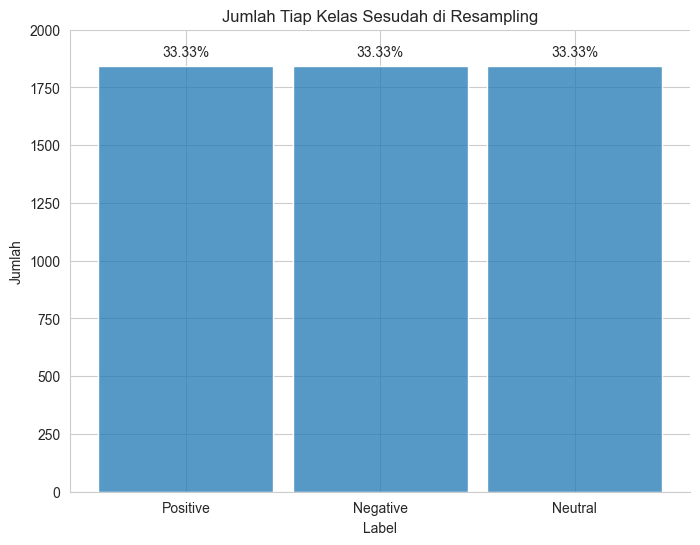

In [20]:
# menampilkan distribusi setelah di resampling
sns.set_style(style='whitegrid')
plt.figure(figsize=(8, 6))

# visualisasi untuk kelas target
ax = sns.histplot(y_resampled, shrink=0.9)
sns.despine(ax=ax, top=True, right=True)

for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(f'{height / float(len(y_resampled)) * 100:.2f}%',
                (bar.get_x() + bar.get_width() / 2, height),
                ha='center', va='center',
                size=10,
                xytext=(0, 10),
                textcoords='offset points',)

# pengaturan plot
plt.title('Jumlah Tiap Kelas Sesudah di Resampling')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.ylim(0, 2000)
plt.show()

In [21]:
# inisialisasi train_size
train_sizes = np.arange(0.5, 0.91, 0.1)

# list untuk menyimpan performa model
train_acc = []
test_acc = []
model_name = []
trains_size = []
train_f1scores = []
test_f1scores = []

for size in train_sizes:
    # splitting data
    features_train, features_test, target_train, target_test = train_test_split(X_resampled, y_resampled, stratify=y_resampled, train_size=size, random_state=12345)

    # Inisialisasi model SVM
    model = SVC(kernel='linear', random_state=12345)
    name = model.__class__.__name__
    # 
    model.fit(features_train, target_train)
    #
    target_pred_train = model.predict(features_train)
    target_pred_test = model.predict(features_test)
    # f1_score
    f1scores_test = f1_score(target_test, target_pred_test, average='macro')
    f1scores_train = f1_score(target_train, target_pred_train, average='macro')
    # accuracy
    accuracy_train = accuracy_score(target_train, target_pred_train)
    accuracy_test = accuracy_score(target_test, target_pred_test)
    # menghitung rata-rata akurasi dari cross-validation
    train_acc.append(accuracy_train)
    test_acc.append(accuracy_test)
    model_name.append(name)
    trains_size.append(f'{size:.0%}')
    train_f1scores.append(f1scores_train)
    test_f1scores.append(f1scores_test)



In [22]:
# performa model dalam bentuk dataframe
result_svm_smote = pd.DataFrame({
    'model_name' : model_name,
    'train_size' : trains_size,
    'train_accuracy' : train_acc,
    'train_f1-score': train_f1scores,
    'test_accuracy' : test_acc,
    'test_f1-score' : test_f1scores
})
result_svm_smote

,model_name,train_size,train_accuracy,train_f1-score,test_accuracy,test_f1-score
0,SVC,50%,0.994571,0.994562,0.971046,0.970814
1,SVC,60%,0.995173,0.995168,0.974672,0.974477
2,SVC,70%,0.996122,0.996119,0.977684,0.977556
3,SVC,80%,0.995701,0.995698,0.981013,0.980901
4,SVC,90%,0.995978,0.995975,0.985533,0.985470


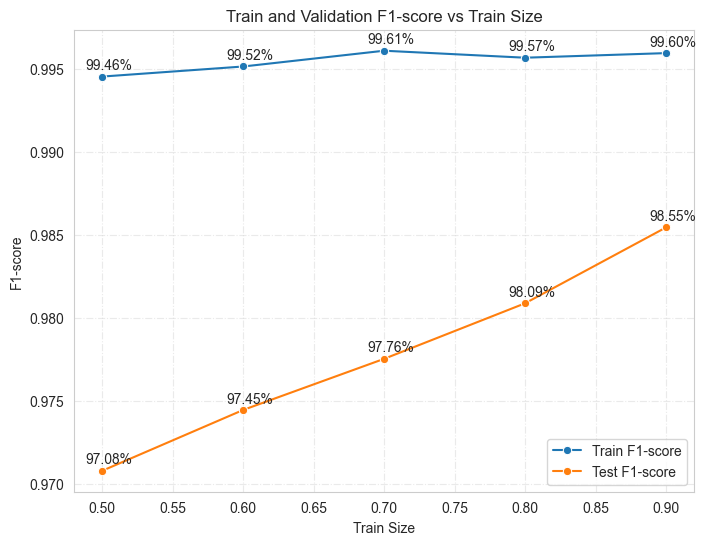

In [23]:
plt.figure(figsize=(8, 6))

# memplot grafik F1-score untuk data latih (Train F1-score) dan data validasi (Test F1-score)
sns.lineplot(x=train_sizes, y=train_f1scores, label='Train F1-score', marker='o')
sns.lineplot(x=train_sizes, y=test_f1scores, label='Test F1-score', marker='o')

# Pengaturan plot
plt.title('Train and Validation F1-score vs Train Size')
plt.xlabel('Train Size')
plt.ylabel('F1-score')
plt.legend(loc='lower right')
plt.grid(True, linestyle='-.', alpha=0.4)
# anotasi untuk setiap titik data
for i, txt in enumerate(test_f1scores):
    plt.annotate(f'{txt:.2%}', (train_sizes[i], test_f1scores[i]), textcoords="offset points", xytext=(5,5), ha='center')
for i, txt in enumerate(train_f1scores):
    plt.annotate(f'{txt:.2%}', (train_sizes[i], train_f1scores[i]), textcoords="offset points", xytext=(5,5), ha='center')

plt.show()


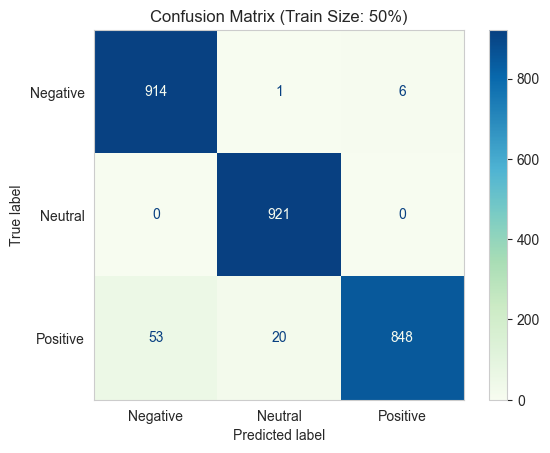

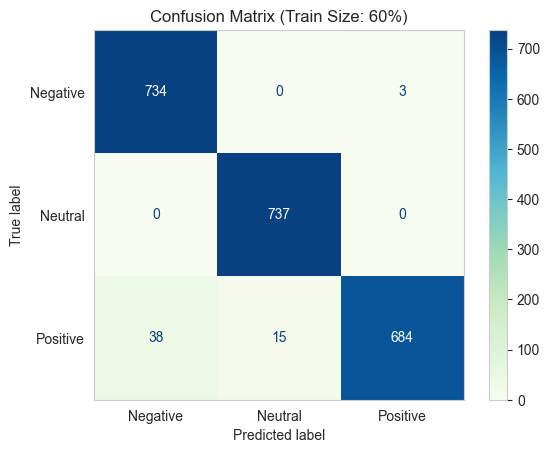

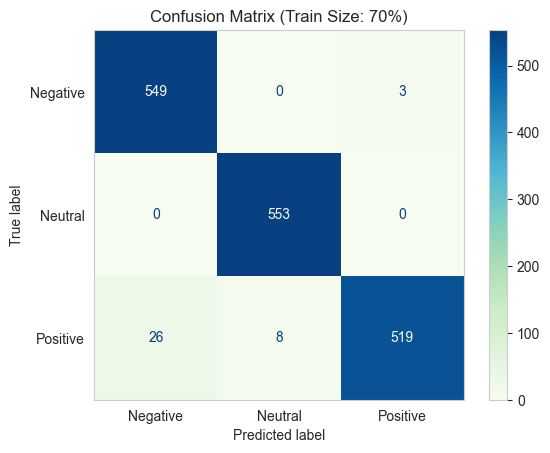

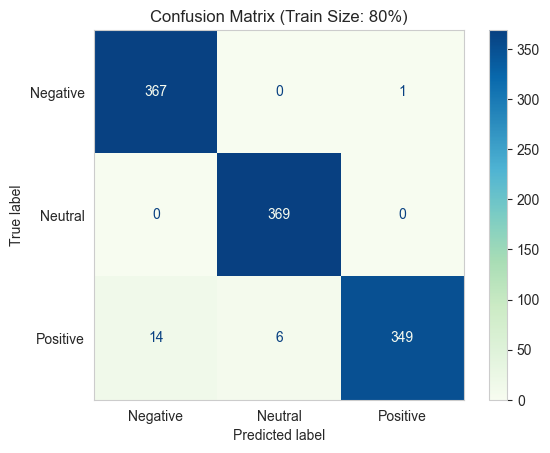

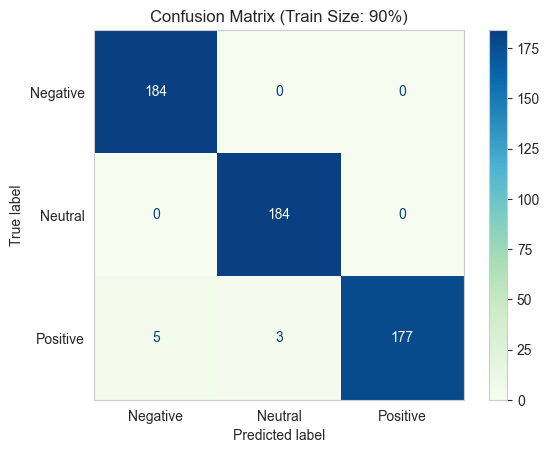

In [24]:
# confusion metriks untuk model dengan balance class  dengan smote
for size in train_sizes:
        # splitting data
        features_train, features_test, target_train, target_test = train_test_split(X_resampled, y_resampled, stratify=y_resampled, train_size=size, random_state=12345)

        # Inisialisasi model SVM
        model = SVC(kernel='linear', random_state=12345)
        name = model.__class__.__name__
        # 
        model.fit(features_train, target_train)
        #
        target_pred_test = model.predict(features_test)
        #
        cm = confusion_matrix(target_test, target_pred_test)
        # Menampilkan confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_resampled))
        disp.plot(cmap=plt.cm.GnBu)
        plt.title(f'Confusion Matrix (Train Size: {size:.0%})')
        plt.grid(False)
        plt.show()

In [25]:
# cclassification report untuk balanced class dengan smote
for size in train_sizes:
        # splitting data
        features_train, features_test, target_train, target_test = train_test_split(X_resampled, y_resampled, stratify=y_resampled, train_size=size, random_state=12345)

        # Inisialisasi model SVM
        model = SVC(kernel='linear', random_state=12345)
        # 
        model.fit(features_train, target_train)
        #
        target_pred_test = model.predict(features_test)

        print(f'Data Training {size:.0%}'.center(55, '-'))
        print(classification_report(target_test, target_pred_test))
        print(55*'=')


-------------------Data Training 50%-------------------
              precision    recall  f1-score   support

    Negative       0.95      0.99      0.97       921
     Neutral       0.98      1.00      0.99       921
    Positive       0.99      0.92      0.96       921

    accuracy                           0.97      2763
   macro avg       0.97      0.97      0.97      2763
weighted avg       0.97      0.97      0.97      2763

-------------------Data Training 60%-------------------
              precision    recall  f1-score   support

    Negative       0.95      1.00      0.97       737
     Neutral       0.98      1.00      0.99       737
    Positive       1.00      0.93      0.96       737

    accuracy                           0.97      2211
   macro avg       0.98      0.97      0.97      2211
weighted avg       0.98      0.97      0.97      2211

-------------------Data Training 70%-------------------
              precision    recall  f1-score   support

    Negative   

# Kesimpulan Umum

1. Dataset ini merupakan komentar atau review pengguna atau pelanggan terhadap produk skincare yang populer di Indonesia dimana jumlah observasi dari data sebanyak 3.006 observasi. Akan tetapi dataset ini terdapat *missing value* dan kita memilih untuk menghapusnya karena data ini merupakan data kualitatif yang berisi komentar dari setiap pelanggan.
2. Kemudian dilakukan tahap data pre-processing, dimana meliputi langkah-langkah berikut ini:
    - Case Folding
    - Data Normalization
    - Tokenizing
    - Filtering Stop Words
    - Stemming
    Setelah melakukan tahap pre-processing, data bersih yang dimiliki sebanyak 2.281 observasi dan data ini siap untuk tahap selanjutnya yaitu EDA dan modeling.
3. Setelah melakukan tahap *Exploratory Data Analysis (EDA)* kita mendapatkan kesimpulan bahwa sentimen pengguna atau pelanggan untuk produk skincare ini termasuk positive, dimana rata-rata pengguna memberikan response atau komentar yang positive terhadap produk dari pada memberikan response yang negative ataupun neutral. Kemudian kita mengetahui bahwa produk skincare ini cukup populer ditahun 2021 dan untuk sekarang sepertinya produk ini mulai mengalami penurunan popularitas, hal ini bisa dibuktikan bahwa untuk komentar atau review setelah tahun 2021 itu berkurang dan bukan bertambah.
4. Kemudian kita melakukan modeling, algoritma yang digunakan adalah *Support Vector Machine* untuk mengklasifikasi sentimen atau opini pengguna skincare tersebut. Akan tetapi data label atau kelas yang dimiliki oleh data itu tidak seimbang maka dilakukan perbandingan performa model untuk yang *imbalance class* dan *balanced class* menggunakan SMOTE. Saat training model, kita menggunakan metriks f1-score untuk melihat bagaimana performa dari model, metriks ini sangat berguna ketika kita memiliki data label yang tidak seimbang (*imbalance*).Alasan kita menggunakan metriks f1-score adalah karena kinerja metrik f1-score sangat penting untuk memberikan gambaran yang lebih baik tentang seberapa baik model  bekerja dalam situasi dimana kelas-kelas memiliki distribusi yang tidak merata.
Dalam situasi di mana kelas-kelas memiliki jumlah sampel yang sangat tidak seimbang (misalnya, kelas mayoritas memiliki frekuensi yang jauh lebih tinggi daripada kelas minoritas). Tidak disarankan untuk menggunakan metriks akurasi karena hal ini dapat menjadi bias terhadap kelas mayoritas dimana artinya model hanya bagus dalam memprediksi kelas mayoritas.
5. Hasil akhirnya kita dapatkan setelah melatih model yang *imbalance class* dan *balanced class* kita mendapati bahwa model dengan *imbalance class* mengalami over fitting dimana artinya performa model hanya bagus untuk data training dan untuk data latih model tidak bekerja dengan baik. Setelah kita melatih model dengan *balanced class* dengan teknik SMOTE kita mendapati hasil model yang maksimal, dimana nilai akurasi sebanyak 99.60% dan nilai f1-score sebanyak 98.55%.